##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

Modified by uramoon@kw.ac.kr

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 전이 학습으로 꽃 분류하기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_feature_vector"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/image_feature_vector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

아름다운 꽃을 보고 어떤 꽃인지 궁금한 적이 있지 않으셨나요? 이 노트북에서는 사진을 보고 꽃을 구분하는 모델을 만들어보겠습니다!

이미지를 분류하기 위해서는 *컨볼루셔널 신경망*이라고 하는 특정 유형의 *심층 신경망*이 특히 강력한 힘을 발휘하는 것으로 입증되었습니다. 그러나 현대의 컨볼루셔널 신경망에는 수백만 개의 매개변수가 있습니다. 처음부터 훈련하려면 레이블이 지정된 많은 훈련 데이터와 많은 컴퓨팅 성능(수백 시간 이상의 GPU 시간)이 필요합니다. 우리에게는 레이블이 붙은 사진이 약 3천장 밖에 없고, 훨씬 적은 시간만 소비하기를 원하므로 더 현명하게 행동해야 합니다.

따라서 우리는 *전이 학습(transfer learning)*이라는 기술을 사용하여 사전 훈련된 네트워크(약 백만 개의 일반 이미지에 대해 훈련됨)를 사용하여 특성을 추출하고 꽃 이미지를 분류하는 작업을 수행할 것입니다.


## 설정


In [1]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

## 꽃 데이터셋

꽃 데이터셋은 꽃 이미지와 5개 중 하나의 클래스 레이블이 기재된 데이터셋입니다.

머신러닝 모델을 훈련할 때 데이터를 훈련 및 테스트 데이터세트로 분할합니다. 훈련 데이터에서 모델을 훈련한 다음 모델이 본 적이 없는 데이터(테스트 세트)에서 모델이 얼마나 잘 동작하는지 평가합니다.

훈련 및 테스트 예제를 다운로드하고(시간이 걸릴 수 있음) 훈련 및 테스트 세트로 나눕니다.

다음 두 개의 셀을 실행합니다.

In [2]:
# 이미지를 FLOWERS_DIR에 다운로드, 이해하실 필요 없습니다.

FLOWERS_DIR = './flower_photos'

def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)

download_images()

Flower photos are located in ./flower_photos


### 꽃 이미지 확인

In [3]:
# 클래스 (하위 디렉토리) 확인, 다섯 종류의 꽃이 있습니다.
!find ./flower_photos -mindepth 1 -type d

./flower_photos/roses
./flower_photos/tulips
./flower_photos/dandelion
./flower_photos/daisy
./flower_photos/sunflowers


종류별로 무작위로 5개의 꽃 그림을 그려봅시다.

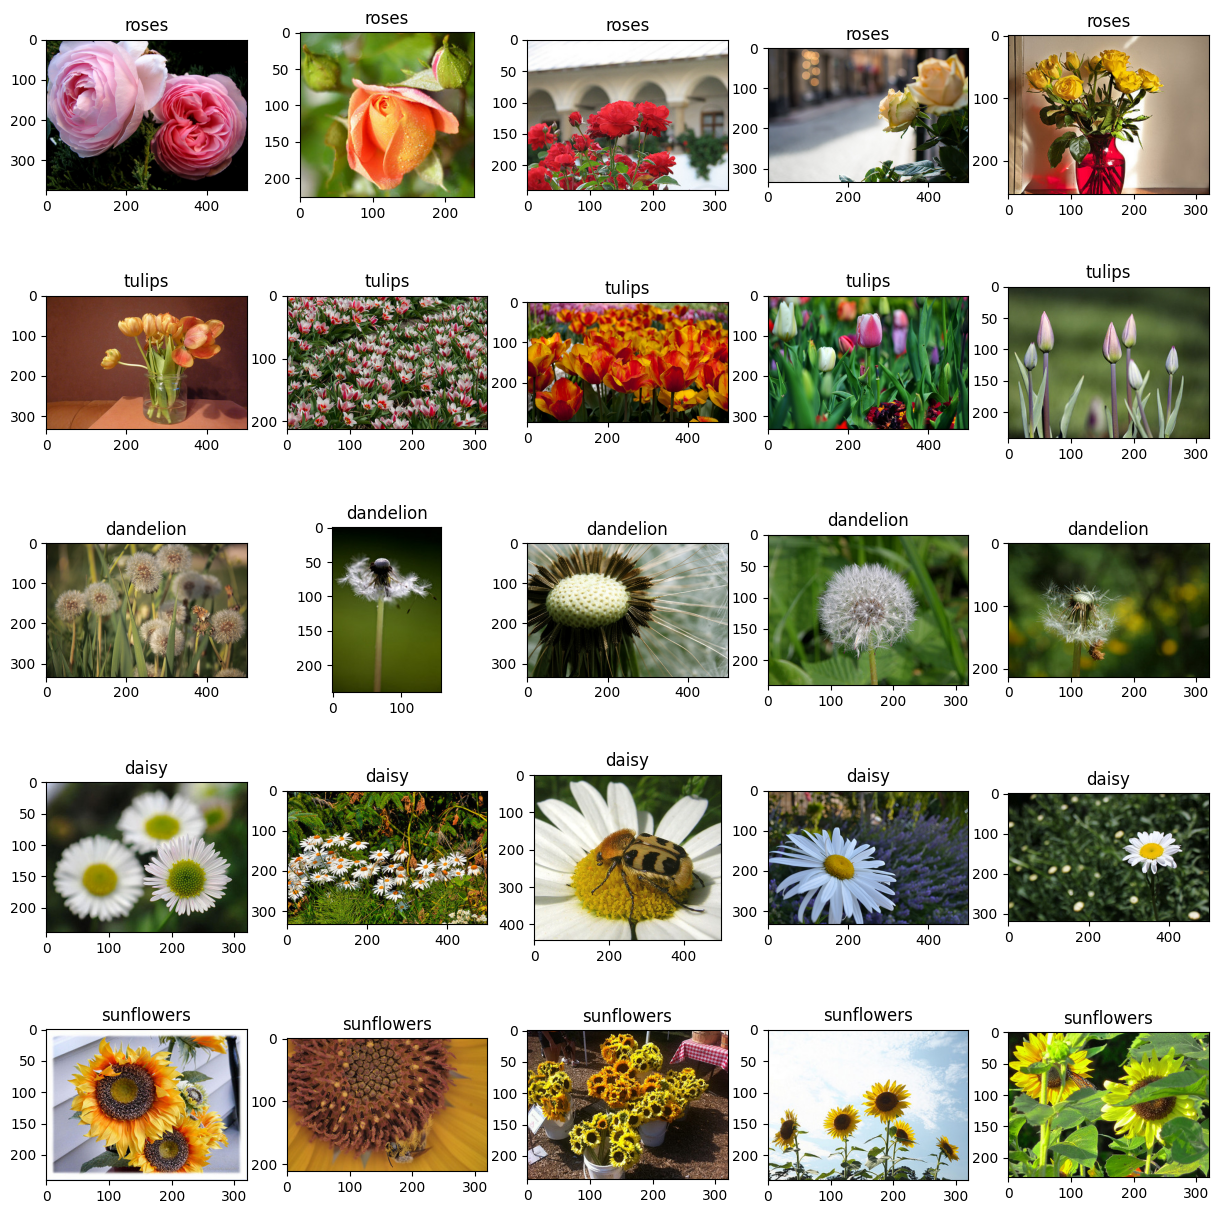

In [4]:
# TODO: FLOWERS_DIR 하위 폴더들 가져오기, Imagewoof 참조
subfolders = [f.path for f in os.scandir(FLOWERS_DIR) if f.is_dir()]

idx = 1 # 몇 번째 그림인지 나타내는 변수
plt.figure(figsize=(15, 15))
# 각 디렉토리에서
for dir in subfolders:  
  # JPEG 파일을 5개씩 무작위로 그리기
  for i in range(5):
    plt.subplot(5, 5, idx) # 5 x 5 격자 모양에서 idx번째 그림 그리기
    idx += 1
    # TODO: Imagewoof 참조
    rand_file = random.choice(os.listdir(dir))
    img = plt.imread(os.path.join(dir, rand_file))
    plt.title(os.path.basename(dir))
    plt.imshow(img)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### 디렉토리에서 데이터셋 만들기
다음의 함수를 이용하여 훈련 데이터셋과 검증 데이터셋만 만듭니다.<br>
테스트셋까지 만들 수도 있지만 여러 귀찮은 작업을 거쳐야하기 때문에 생략합니다.<br>
https://keras.io/api/preprocessing/image/<br>
기본 설정에서 레이블은 0, 1, 2, ...와 같은 정수로 저장되어 sparse_categorical_crossentropy loss를 사용하기에 적합합니다.

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

seed = 42
# 우리가 사용할 Inception에서 입력받을 이미지 사이즈
size = (150, 150)

# TODO: 훈련 데이터 만들기 
train_ds = image_dataset_from_directory(FLOWERS_DIR, validation_split=0.2, subset="training", seed=seed, image_size=size)

# TODO: 검증 데이터 만들기
val_ds = image_dataset_from_directory(FLOWERS_DIR, validation_split=0.2, subset="validation", seed=seed, image_size=size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### 데이터셋 전처리하기



In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# TODO: 람다 함수를 사용해 각 데이터셋의 x (이미지)에만 preprocess_input을 적용해보세요.
# 각 픽셀값이 -1 ~ 1로 변환됩니다.
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

### 훈련 데이터셋 확인하기
훈련 데이터셋에서 무작위로 다섯 개의 이미지와 레이블을 표시해보세요.<br>
(사이즈는 150 x 150, 레이블은 0 ~ 4인지 확인해 보세요.)

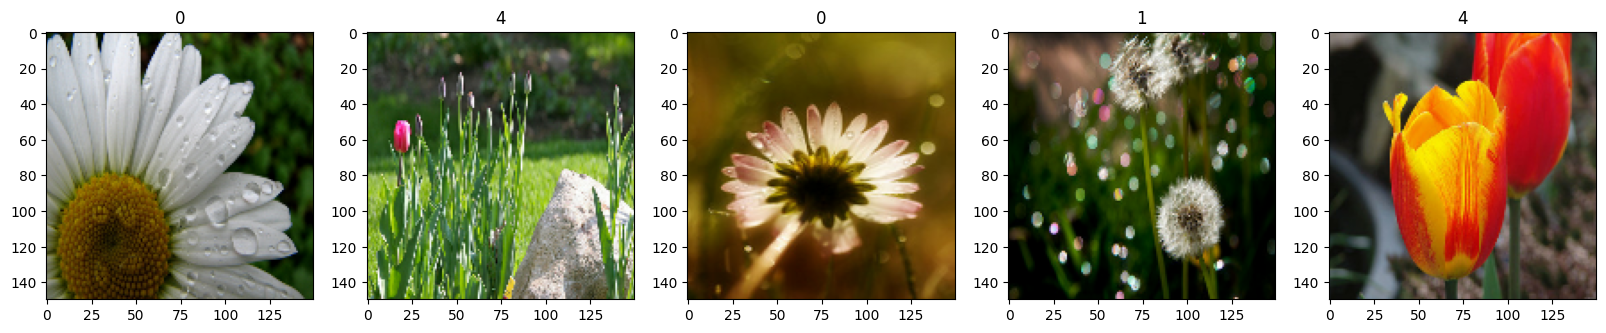

In [7]:
# TODO: 훈련 데이터셋에서 한 묶음 가져와서 그림들과 레이블 분리하기
batch, = train_ds.take(1)
images, labels = batch

plt.figure(figsize=(20, 20))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow((images[i] + 1) / 2)#TODO: [-1, 1]로 되어 있으니 제대로 그리려면 [0, 1] 등으로 변경해 주세요.)
  plt.title(str(labels[i].numpy()))#TODO: str()로 묶어서 어떤 클래스인지 숫자가 포함된 형태로 출력해도 됩니다.)

## 모델 빌드하기

ImageNet으로 훈련된 InceptionV3를 사용하여 전이학습 모델을 만들어보세요.

<img src="https://production-media.paperswithcode.com/datasets/ImageNet-0000000008-f2e87edd_Y0fT5zg.jpg" height="400"><figcaption>Imagenet, 출처: https://cs.stanford.edu/people/karpathy/cnnembed/</figcaption>

In [24]:
# TODO: 모델을 정의하고 컴파일까지 수행하세요. 출력 모양, 활성화 함수 및 loss에 주의하세요!
# HInt: https://keras.io/api/applications/ and Transfer Learning 노트북
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# InceptionV3 모델 불러오기 (ImageNet으로 사전 훈련된 가중치 포함)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# 특성 추출 부분 위에 새로운 분류기 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# 전체 모델 생성
model = Model(inputs=base_model.input, outputs=predictions)

# 기존의 InceptionV3 모델 부분은 학습되지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 컴파일
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

## 네트워크 훈련하기

이제 모델을 빌드했으므로 모델을 훈련하고 **검증 데이터셋에서의 정확도**를 확인합니다.

In [26]:
from keras.callbacks import EarlyStopping

# TODO: 자유롭게 설정하세요.
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
epochs = 10000
model.fit(train_ds, epochs=epochs, callbacks=es, validation_data=val_ds)#: 위에서 우리가 만든 검증 데이터셋 입력)

Epoch 1/10000
92/92 [==============================] - 14s 87ms/step - loss: 1.4057 - accuracy: 0.7030 - val_loss: 0.5330 - val_accuracy: 0.8147
Epoch 2/10000
92/92 [==============================] - 7s 76ms/step - loss: 0.4115 - accuracy: 0.8542 - val_loss: 0.6152 - val_accuracy: 0.8093
Epoch 3/10000
92/92 [==============================] - 7s 76ms/step - loss: 0.2941 - accuracy: 0.8975 - val_loss: 0.6183 - val_accuracy: 0.8188
Epoch 4/10000
92/92 [==============================] - 6s 62ms/step - loss: 0.2395 - accuracy: 0.9145 - val_loss: 0.6080 - val_accuracy: 0.8256
Epoch 5/10000
92/92 [==============================] - 7s 75ms/step - loss: 0.1661 - accuracy: 0.9469 - val_loss: 0.6688 - val_accuracy: 0.8365
Epoch 6/10000
92/92 [==============================] - 6s 61ms/step - loss: 0.1237 - accuracy: 0.9591 - val_loss: 0.7908 - val_accuracy: 0.8174
Epoch 7/10000
92/92 [==============================] - 6s 62ms/step - loss: 0.1047 - accuracy: 0.9629 - val_loss: 0.7846 - val_accuracy

## iNaturalist로 훈련한 모델 이용하기
ImageNet으로 훈련한 모델보다 더 좋은 결과를 얻을 수 있을까요?<br>
<img src="https://github.com/visipedia/inat_comp/raw/master/2017/assets/inat_2017_banner.jpg" height="250"><figcaption>iNaturalist Dataset, 출처: https://github.com/visipedia/inat_comp/tree/master/2017</figcaption>

In [28]:
model = tf.keras.Sequential([
    # TODO: 데이터 증강층 기재, 
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5",
                   trainable=False),     
    tf.keras.layers.Dense(5, activation='softmax') # 출력층 기재
])

# TODO: 모델 컴파일    
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



상기 모델을 훈련해봅시다.

In [29]:
model.fit(train_ds, epochs=epochs, callbacks=es, validation_data=val_ds)


Epoch 1/10000


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 13s 69ms/step - loss: 0.7728 - accuracy: 0.7391 - val_loss: 0.4778 - val_accuracy: 0.8297
Epoch 2/10000
92/92 [==============================] - 8s 84ms/step - loss: 0.4045 - accuracy: 0.8576 - val_loss: 0.4573 - val_accuracy: 0.8392
Epoch 3/10000
92/92 [==============================] - 8s 77ms/step - loss: 0.3286 - accuracy: 0.8804 - val_loss: 0.4920 - val_accuracy: 0.8283
Epoch 4/10000
92/92 [==============================] - 6s 62ms/step - loss: 0.2934 - accuracy: 0.8965 - val_loss: 0.4460 - val_accuracy: 0.8556
Epoch 5/10000
92/92 [==============================] - 7s 69ms/step - loss: 0.2924 - accuracy: 0.8958 - val_loss: 0.3866 - val_accuracy: 0.8678
Epoch 6/10000
92/92 [==============================] - 7s 76ms/step - loss: 0.2524 - accuracy: 0.9091 - val_loss: 0.4462 - val_accuracy: 0.8433
Epoch 7/10000
92/92 [==============================] - 6s 62ms/step - loss: 0.2328 - accuracy: 0.9135 - val_loss: 0.4344 - val_accuracy: 0.8597
Epoch

## 수고하셨습니다.
아래의 글들은 참고로 읽어보세요. (우리는 모바일넷 대신 Inception 사용했음)

## 연습: 모델을 개선하세요!

앞서 기준 모델을 훈련했습니다. 이제 더 높은 정확성을 얻기 위해 모델을 개선해 보겠습니다(변경 시 셀을 다시 실행해야 함).

### 연습 1: 다른 이미지 모델을 사용해 봅니다.

TF-Hub에서 몇 가지 다른 이미지 모델을 간단히 시도해 볼 수 있습니다. `hub.Module()` 호출에서 `"https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2"` 핸들을 다른 모듈의 핸들로 대체하고 모든 코드를 다시 실행하기만 하면 됩니다. [tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector)에서 사용 가능한 모든 이미지 모듈을 볼 수 있습니다.

다른 [MobileNet V2 모듈](https://tfhub.dev/s?module-type=image-feature-vector&network-architecture=mobilenet-v2) 중 하나를 선택하는 것이 좋습니다. MobileNet 모듈을 포함한 많은 모듈은 1백만 개 이상의 이미지와 1000개의 클래스가 포함된 [ImageNet 데이터세트](http://image-net.org/challenges/LSVRC/2012/index#task)에서 훈련되었습니다. 네트워크 아키텍처를 선택하면 속도와 분류 정확성 사이에서 균형이 유지됩니다. MobileNet 또는 NASNet Mobile과 같은 모델은 빠르고 작으며 Inception 및 ResNet과 같은 보다 전통적인 아키텍처는 정확성을 위주로 설계되었습니다.

보다 큰 Inception V3 아키텍처의 경우, 고유한 작업에 더 가까운 도메인에서 사전 훈련하는 이점을 모색할 수도 있습니다. 식물과 동물의 [iNaturalist 데이터세트에서 훈련한 모듈](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1)로 사용할 수도 있습니다.

### 연습 2: 숨겨진 레이어를 추가합니다.

추출된 이미지 특성과 선형 분류자 사이에 숨겨진 레이어 스택을 넣습니다(위의 `create_model()` 함수). 예를 들어 100개의 노드가 있는 비선형의 숨겨진 레이어를 만들려면 단위를 100으로 설정하고 활성화를 `tf.nn.relu`로 설정하여 [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/compat/v1/layers/dense)를 사용합니다. 숨겨진 레이어의 크기를 변경하면 테스트 정확성에 영향을 미칩니까? 두 번째 숨겨진 레이어를 추가하면 정확성이 개선됩니까?

### 연습3 : 하이퍼 매개변수를 변경합니다.

*훈련 스텝 수*를 늘리면 최종 정확성이 개선됩니까? 모델이 더 빠르게 수렴하도록 *학습률을 변경*할 수 있습니까? 훈련 *배치 크기*가 모델의 성능에 영향을 미칩니까?

### 연습 4: 다른 옵티마이저를 사용해 봅니다.

기본 GradientDescentOptimizer를 더 정교한 [옵티마이저](https://www.tensorflow.org/api_guides/python/train#Optimizers)(예: [AdagradOptimizer](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/AdagradOptimizer))로 교체합니다. 그렇게 했을 때 모델 훈련에 차이가 있습니까? 다양한 최적화 알고리즘의 이점에 대해 자세히 알아보려면 [이 게시물](http://ruder.io/optimizing-gradient-descent/)을 확인하세요.

## 더 알고 싶습니까?

이 튜토리얼의 고급 버전에 관심이 있다면 TensorBoard를 사용하여 훈련을 시각화하는 과정을 안내하는 [TensorFlow 이미지 재훈련 튜토리얼](https://www.tensorflow.org/hub/tutorials/image_retraining), 이미지 왜곡을 이용한 데이터세트 확대와 같은 고급 기술, 고유한 데이터세트에서 이미지 분류자를 학습하기 위해 꽃 데이터세트를 교체하는 방법에 대해 알아보세요.

[tensorflow.org](http://tensorflow.org)에서 TensorFlow에 대해 자세히 알아보고 [tensorflow.org/hub](https://www.tensorflow.org/hub/)에서 TF-Hub API 설명서를 참조할 수 있습니다. 더 많은 이미지 특성 벡터 모듈 및 텍스트 임베딩 모듈을 포함하여 [tfhub.dev](http://tfhub.dev)에서 사용 가능한 TensorFlow 허브 모듈을 찾아보세요.

빠르게 진행되는 Google의 머신러닝 실무 개요 과정인 [머신러닝 집중 과정](https://developers.google.com/machine-learning/crash-course/)을 확인해 보세요.